In [2]:
import code_tokenize
import re
def my_tokenizer(text):
    text = re.sub(r'\b\d+\.\d+\b', lambda x: str(float(x.group())), text)
    tokens = code_tokenize.tokenize(text, lang="c", syntax_error="ignore")
    tokens_list = [str(x) for x in tokens]
    return tokens_list

In [3]:
# tokenize the data that can be used by embeddings
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import pickle

# root_dir = '/home/shaurya/BTP/1/'
# dataset_dir = '/home/shaurya/BTP/1/Outputs/CSV'
tokenizer_path = "F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Tokenizers//tokenizerClubbed.pkl"
retrain = False
if os.path.exists(tokenizer_path) and not retrain:
    print("[INFO] Loading saved tokenizer")
    with open(tokenizer_path, "rb") as tokenizer_file:
        tokenizer = pickle.load(tokenizer_file)
else:
    print("Not found")   

[INFO] Loading saved tokenizer


# CustomDATA LSTM w2v

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs
1
2


C:\Users\shaur\miniconda3\envs\tf\lib\site-packages\tree_sitter\__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


3
4
5
6
DEBUG:tensorflow:Layer LSTM_W2V_1 will use cuDNN kernels when running on GPU.


DEBUG:tensorflow:Layer LSTM_W2V_1 will use cuDNN kernels when running on GPU.


DEBUG:tensorflow:Layer LSTM_W2V_2 will use cuDNN kernels when running on GPU.


DEBUG:tensorflow:Layer LSTM_W2V_2 will use cuDNN kernels when running on GPU.


Epoch 1/30
51/51 [==============================] - 9s 134ms/step - loss: 0.6701 - accuracy: 0.7548 - val_loss: 0.4072 - val_accuracy: 0.8364
Epoch 2/30
51/51 [==============================] - 7s 133ms/step - loss: 0.3932 - accuracy: 0.8386 - val_loss: 0.4035 - val_accuracy: 0.8375
Epoch 3/30
51/51 [==============================] - 7s 133ms/step - loss: 0.3917 - accuracy: 0.8386 - val_loss: 0.4018 - val_accuracy: 0.8386
Epoch 4/30
51/51 [==============================] - 7s 132ms/step - loss: 0.3917 - accuracy: 0.8393 - val_loss: 0.4019 - val_accuracy: 0.8386
Epoch 5/30
51/51 [==============================] - 7s 132ms/step - loss: 0.3910 - accuracy: 0.8389 - val_loss: 0.4020 - val_accuracy: 0.8386
Epoch 6/30
51/51 [==============================] - 7s 132ms/step - loss: 0.3981 - accuracy: 0.8393 - val_loss: 0.3991 - val_accuracy: 0.8386
Epoch 7/30
51/51 [==============================] - 7s 133ms/step - loss: 0.4097 - accuracy: 0.8215 - val_loss: 0.3986 - val_accuracy: 0.8386
Epoch 

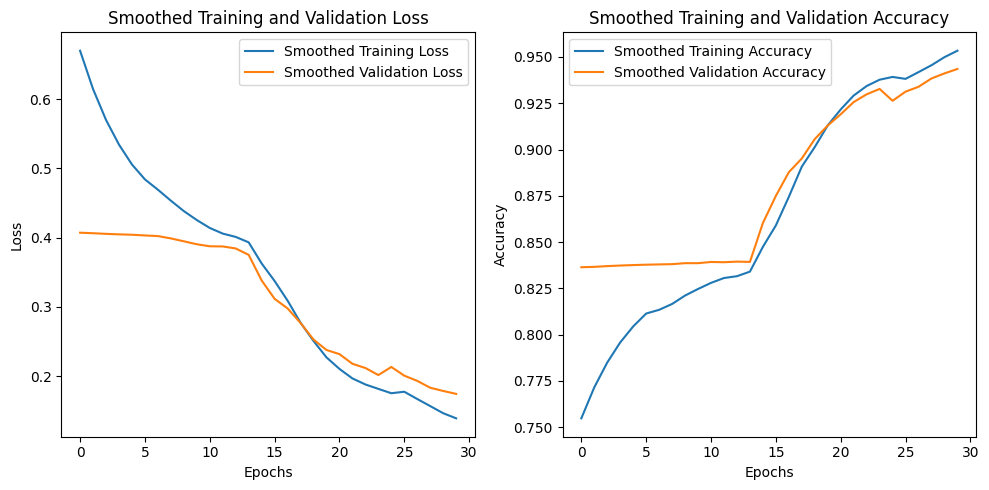

15/15 [==============================] - 1s 34ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       247
           1       0.95      0.98      0.97       212

    accuracy                           0.97       459
   macro avg       0.97      0.97      0.97       459
weighted avg       0.97      0.97      0.97       459

Confusion Matrix:
[[236  11]
 [  4 208]]


In [4]:
import os
import pandas as pd
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2



os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def tokenize_sequences(X_train, X_test, X_val, tokenizer):
    X_train = [str(code) for code in X_train]  # Convert any non-string elements to string
    X_train = tokenizer.texts_to_sequences(X_train)

    X_val = [str(code) for code in X_val]  # Convert any non-string elements to string
    X_val = tokenizer.texts_to_sequences(X_val)

    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length_train = max(len(sequence) for sequence in X_train)
    max_length_val = max(len(sequence) for sequence in X_val)
    max_length_test = max(len(sequence) for sequence in X_test)

    maxlen = 1000

    X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
    X_val = pad_sequences(X_val, padding="post", maxlen=maxlen)
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

    return X_train, X_val, X_test

def load_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".c"):
                file_path = os.path.join(root, file)
                file_list.append(file_path)
    return file_list

    
def load_data():
    # Function to load files from a directory
    # Code for embeddings:
    dataset_directory = "F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//Raw//dataset 1//Dataset_raw"
    vulnerable_dir = os.path.join(dataset_directory, "Vulnerable")
    non_vulnerable_dir = os.path.join(dataset_directory, "Non_vulnerable")
    
    # Load training and test files for vulnerable and non-vulnerable classes
    vulnerable__files = load_files(vulnerable_dir)
    non_vulnerable_files = load_files(non_vulnerable_dir)
    
    import pandas as pd
    
    file_paths = vulnerable__files + non_vulnerable_files
    
    df = pd.DataFrame(columns=["func", "target"])  # Include "target" column

    for file_path in file_paths:
        try:
            with open(file_path, 'r') as f:
                code = f.read()
                if code:  # Check if code is not empty
                    target = 1 if file_path in vulnerable__files else 0  # Assign target based on origin
                    new_row = [{"func": code, "target": target}]
                    df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
        except FileNotFoundError:
            print(f"Warning: File not found: {file_path}")
    
    # Shuffle the data
    df_filtered = shuffle(df, random_state=42)
    
    # Determine the indices for splitting
    total_samples = len(df_filtered)
    train_end_index = int(total_samples * 0.7)
    val_end_index = int(train_end_index + (total_samples * 0.2))

    X_train = df_filtered['func'][:train_end_index]
    X_val = df_filtered['func'][train_end_index:val_end_index]
    X_test = df_filtered['func'][val_end_index:]

    y_train = df_filtered['target'][:train_end_index]
    y_val = df_filtered['target'][train_end_index:val_end_index]
    y_test = df_filtered['target'][val_end_index:]

    return X_train, X_val, X_test, y_train, y_val, y_test





def load_embedding_model(x):
  filename = f'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Embedding Models Combined//word2vec_c_{x}_model.pkl'

  with open(filename, 'rb') as f:
    embedding_model = pickle.load(f)

  return embedding_model


def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='LSTM_W2V_EL'))
    model.add(LSTM(units=128, return_sequences=True, name='LSTM_W2V_1', dropout=0.1))
    model.add(LSTM(units=128, name='LSTM_W2V_2'))
    model.add(Dense(units=2, activation='softmax', name='LSTM_W2V_OL'))    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model



def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)  

    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    report = classification_report(y_test, y_pred)
    print(report)

    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"/home/shaurya/BTP/1/Outputs/Checkpoints/Sentence/LSTM/Word2vec/model10k_fold_{fold}.h5")

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points



print("1")
# Tokenize the sequences
X_train, X_val, X_test, y_train, y_val, y_test = load_data()
print("2")

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



X_train_padded, X_val_padded, test_padded = tokenize_sequences(X_train, X_test, X_val, tokenizer)
print("3")


embedding_dims = [50]

for embedding_dim in embedding_dims:
    print("4")

    embedding_model = load_embedding_model(embedding_dim)
    print("5")

    
    # Create the embedding matrix
    embedding_dim = embedding_dim
    vocab_size = 2398616
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in embedding_model.wv:
            embedding_matrix[i] = embedding_model.wv[word]
    print("6")
    # Create a sequential model
    model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])
          
    
    history = model.fit(X_train_padded, y_train, epochs=30, batch_size=64, validation_data=(X_val_padded, y_val))
    model.summary()
    
    # Plot both loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size as desired
    plt.subplot(1, 2, 1)  # Create subplot for loss
    smoothed_loss = smooth_curve(history.history['loss'])
    smoothed_val_loss = smooth_curve(history.history['val_loss'])
    plt.plot(smoothed_loss, label='Smoothed Training Loss')
    plt.plot(smoothed_val_loss, label='Smoothed Validation Loss')
    plt.title('Smoothed Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    smoothed_acc = smooth_curve(history.history['accuracy'])
    smoothed_val_acc = smooth_curve(history.history['val_accuracy'])
    plt.plot(smoothed_acc, label='Smoothed Training Accuracy')
    plt.plot(smoothed_val_acc, label='Smoothed Validation Accuracy')
    plt.title('Smoothed Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

    # Evaluate the model using the test set
    evaluate_model(test_padded, y_test, model)
    
    # Predict on the additional test set
    # test_pred = predict_additional_data(test_padded, model)        

    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//Custom/LSTM_w2v_{embedding_dim}.keras")

# CustomDATA LSTM ft

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs
1
2


C:\Users\shaur\miniconda3\envs\tf\lib\site-packages\tree_sitter\__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


3
4
5
6
DEBUG:tensorflow:Layer LSTM_W2V_1 will use cuDNN kernels when running on GPU.


DEBUG:tensorflow:Layer LSTM_W2V_1 will use cuDNN kernels when running on GPU.


DEBUG:tensorflow:Layer LSTM_W2V_2 will use cuDNN kernels when running on GPU.


DEBUG:tensorflow:Layer LSTM_W2V_2 will use cuDNN kernels when running on GPU.


Epoch 1/30
51/51 [==============================] - 8s 138ms/step - loss: 0.4742 - accuracy: 0.8327 - val_loss: 0.4010 - val_accuracy: 0.8386
Epoch 2/30
51/51 [==============================] - 7s 138ms/step - loss: 0.3897 - accuracy: 0.8399 - val_loss: 0.3994 - val_accuracy: 0.8397
Epoch 3/30
51/51 [==============================] - 7s 137ms/step - loss: 0.4592 - accuracy: 0.8081 - val_loss: 0.4051 - val_accuracy: 0.8364
Epoch 4/30
51/51 [==============================] - 7s 139ms/step - loss: 0.3920 - accuracy: 0.8386 - val_loss: 0.4004 - val_accuracy: 0.8375
Epoch 5/30
51/51 [==============================] - 7s 138ms/step - loss: 0.3883 - accuracy: 0.8389 - val_loss: 0.3958 - val_accuracy: 0.8386
Epoch 6/30
51/51 [==============================] - 7s 137ms/step - loss: 0.3819 - accuracy: 0.8393 - val_loss: 0.3894 - val_accuracy: 0.8386
Epoch 7/30
51/51 [==============================] - 7s 136ms/step - loss: 0.3811 - accuracy: 0.8393 - val_loss: 0.3843 - val_accuracy: 0.8408
Epoch 

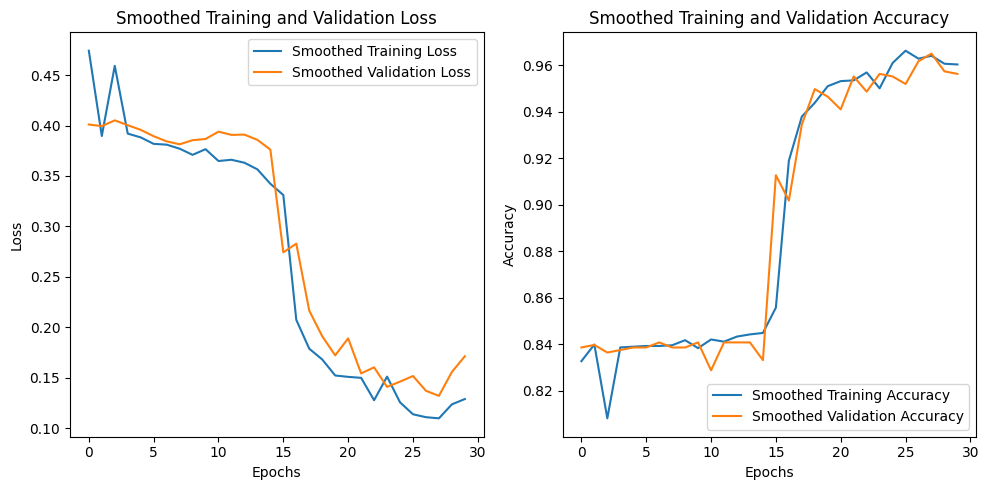

15/15 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       247
           1       0.96      0.93      0.95       212

    accuracy                           0.95       459
   macro avg       0.95      0.95      0.95       459
weighted avg       0.95      0.95      0.95       459

Confusion Matrix:
[[238   9]
 [ 14 198]]


In [4]:
import os
import pandas as pd
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2



os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def tokenize_sequences(X_train, X_test, X_val, tokenizer):
    X_train = [str(code) for code in X_train]  # Convert any non-string elements to string
    X_train = tokenizer.texts_to_sequences(X_train)

    X_val = [str(code) for code in X_val]  # Convert any non-string elements to string
    X_val = tokenizer.texts_to_sequences(X_val)

    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length_train = max(len(sequence) for sequence in X_train)
    max_length_val = max(len(sequence) for sequence in X_val)
    max_length_test = max(len(sequence) for sequence in X_test)

    maxlen = 1000

    X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
    X_val = pad_sequences(X_val, padding="post", maxlen=maxlen)
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

    return X_train, X_val, X_test

def load_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".c"):
                file_path = os.path.join(root, file)
                file_list.append(file_path)
    return file_list

    
def load_data():
    # Function to load files from a directory
    # Code for embeddings:
    dataset_directory = "F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//Raw//dataset 1//Dataset_raw"
    vulnerable_dir = os.path.join(dataset_directory, "Vulnerable")
    non_vulnerable_dir = os.path.join(dataset_directory, "Non_vulnerable")
    
    # Load training and test files for vulnerable and non-vulnerable classes
    vulnerable__files = load_files(vulnerable_dir)
    non_vulnerable_files = load_files(non_vulnerable_dir)
    
    import pandas as pd
    
    file_paths = vulnerable__files + non_vulnerable_files
    
    df = pd.DataFrame(columns=["func", "target"])  # Include "target" column

    for file_path in file_paths:
        try:
            with open(file_path, 'r') as f:
                code = f.read()
                if code:  # Check if code is not empty
                    target = 1 if file_path in vulnerable__files else 0  # Assign target based on origin
                    new_row = [{"func": code, "target": target}]
                    df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)
        except FileNotFoundError:
            print(f"Warning: File not found: {file_path}")
    
    # Shuffle the data
    df_filtered = shuffle(df, random_state=42)
    
    # Determine the indices for splitting
    total_samples = len(df_filtered)
    train_end_index = int(total_samples * 0.7)
    val_end_index = int(train_end_index + (total_samples * 0.2))

    X_train = df_filtered['func'][:train_end_index]
    X_val = df_filtered['func'][train_end_index:val_end_index]
    X_test = df_filtered['func'][val_end_index:]

    y_train = df_filtered['target'][:train_end_index]
    y_val = df_filtered['target'][train_end_index:val_end_index]
    y_test = df_filtered['target'][val_end_index:]

    return X_train, X_val, X_test, y_train, y_val, y_test





def load_embedding_model(x):
  filename = f'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Embedding Models Combined//fasttext_c_{x}_model.pkl'

  with open(filename, 'rb') as f:
    embedding_model = pickle.load(f)

  return embedding_model


def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='LSTM_W2V_EL'))
    model.add(LSTM(units=128, return_sequences=True, name='LSTM_W2V_1', dropout=0.1))
    model.add(LSTM(units=128, name='LSTM_W2V_2'))
    model.add(Dense(units=2, activation='softmax', name='LSTM_W2V_OL'))    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model



def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)  

    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    report = classification_report(y_test, y_pred)
    print(report)

    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"/home/shaurya/BTP/1/Outputs/Checkpoints/Sentence/LSTM/Word2vec/model10k_fold_{fold}.h5")

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points



print("1")
# Tokenize the sequences
X_train, X_val, X_test, y_train, y_val, y_test = load_data()
print("2")

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



X_train_padded, X_val_padded, test_padded = tokenize_sequences(X_train, X_test, X_val, tokenizer)
print("3")


embedding_dims = [50]

for embedding_dim in embedding_dims:
    print("4")

    embedding_model = load_embedding_model(embedding_dim)
    print("5")

    
    # Create the embedding matrix
    embedding_dim = embedding_dim
    vocab_size = 2398616
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in embedding_model.wv:
            embedding_matrix[i] = embedding_model.wv[word]
    print("6")
    # Create a sequential model
    model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])
          
    
    history = model.fit(X_train_padded, y_train, epochs=30, batch_size=64, validation_data=(X_val_padded, y_val))
    model.summary()
    
    # Plot both loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size as desired
    plt.subplot(1, 2, 1)  # Create subplot for loss
    smoothed_loss = (history.history['loss'])
    smoothed_val_loss = (history.history['val_loss'])
    plt.plot(smoothed_loss, label='Smoothed Training Loss')
    plt.plot(smoothed_val_loss, label='Smoothed Validation Loss')
    plt.title('Smoothed Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    smoothed_acc = (history.history['accuracy'])
    smoothed_val_acc = (history.history['val_accuracy'])
    plt.plot(smoothed_acc, label='Smoothed Training Accuracy')
    plt.plot(smoothed_val_acc, label='Smoothed Validation Accuracy')
    plt.title('Smoothed Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

    # Evaluate the model using the test set
    evaluate_model(test_padded, y_test, model)
    
    # Predict on the additional test set
    # test_pred = predict_additional_data(test_padded, model)        

    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//Custom/LSTM_ft_customData_{embedding_dim}.keras")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs
1
2


C:\Users\shaur\miniconda3\envs\tf\lib\site-packages\tree_sitter\__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


3
4
5
6
DEBUG:tensorflow:Layer LSTM_W2V_1 will use cuDNN kernels when running on GPU.


DEBUG:tensorflow:Layer LSTM_W2V_1 will use cuDNN kernels when running on GPU.


DEBUG:tensorflow:Layer LSTM_W2V_2 will use cuDNN kernels when running on GPU.


DEBUG:tensorflow:Layer LSTM_W2V_2 will use cuDNN kernels when running on GPU.


Epoch 1/30
1301/1301 [==============================] - 228s 176ms/step - loss: 0.4248 - accuracy: 0.8430 - val_loss: 0.4289 - val_accuracy: 0.8404
Epoch 2/30
1301/1301 [==============================] - 229s 176ms/step - loss: 0.4109 - accuracy: 0.8444 - val_loss: 0.3885 - val_accuracy: 0.8412
Epoch 3/30
1301/1301 [==============================] - 228s 175ms/step - loss: 0.3634 - accuracy: 0.8531 - val_loss: 0.3443 - val_accuracy: 0.8616
Epoch 4/30
1301/1301 [==============================] - 228s 175ms/step - loss: 0.3360 - accuracy: 0.8671 - val_loss: 0.3273 - val_accuracy: 0.8672
Epoch 5/30
1301/1301 [==============================] - 228s 175ms/step - loss: 0.3164 - accuracy: 0.8760 - val_loss: 0.3156 - val_accuracy: 0.8730
Epoch 6/30
1301/1301 [==============================] - 228s 175ms/step - loss: 0.3020 - accuracy: 0.8815 - val_loss: 0.3129 - val_accuracy: 0.8741
Epoch 7/30
1301/1301 [==============================] - 228s 175ms/step - loss: 0.2909 - accuracy: 0.8853 - val_

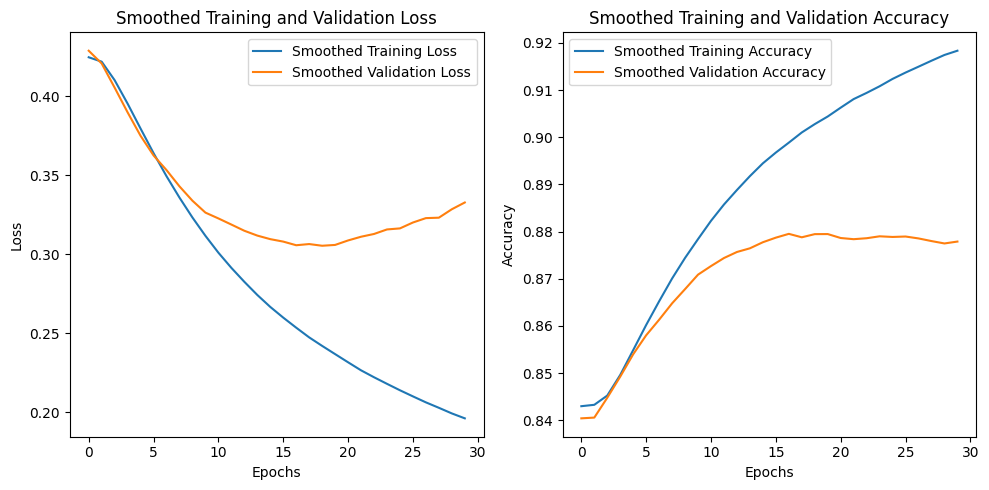

372/372 [==============================] - 15s 40ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     10015
           1       0.66      0.49      0.56      1880

    accuracy                           0.88     11895
   macro avg       0.78      0.72      0.75     11895
weighted avg       0.87      0.88      0.87     11895

Confusion Matrix:
[[9534  481]
 [ 961  919]]


In [5]:
import os
import pandas as pd
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2



os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def tokenize_sequences(X_train, X_test, X_val, tokenizer):
    X_train = [str(code) for code in X_train]  # Convert any non-string elements to string
    X_train = tokenizer.texts_to_sequences(X_train)

    X_val = [str(code) for code in X_val]  # Convert any non-string elements to string
    X_val = tokenizer.texts_to_sequences(X_val)

    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length_train = max(len(sequence) for sequence in X_train)
    max_length_val = max(len(sequence) for sequence in X_val)
    max_length_test = max(len(sequence) for sequence in X_test)

    maxlen = 1000

    X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
    X_val = pad_sequences(X_val, padding="post", maxlen=maxlen)
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

    return X_train, X_val, X_test
    
def load_data():
    df = pd.read_csv('F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//CSVs//preprocessed_df_100k.csv')
    df_target_0 = df[df['target'] == 0]
    df_target_1 = df[df['target'] == 1]

    df_filtered = pd.concat([df_target_0, df_target_1], ignore_index=True)
    
    # Shuffle the data
    df_filtered = shuffle(df_filtered, random_state=42)
    
    # Determine the indices for splitting
    total_samples = len(df_filtered)
    train_end_index = int(total_samples * 0.7)
    val_end_index = int(train_end_index + (total_samples * 0.2))

    X_train = df_filtered['func'][:train_end_index]
    X_val = df_filtered['func'][train_end_index:val_end_index]
    X_test = df_filtered['func'][val_end_index:]

    y_train = df_filtered['target'][:train_end_index]
    y_val = df_filtered['target'][train_end_index:val_end_index]
    y_test = df_filtered['target'][val_end_index:]

    return X_train, X_val, X_test, y_train, y_val, y_test





def load_embedding_model(x):
  filename = f'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Embedding Models Combined//fasttext_c_{x}_model.pkl'

  with open(filename, 'rb') as f:
    embedding_model = pickle.load(f)

  return embedding_model

def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='LSTM_W2V_EL'))
    model.add(LSTM(units=128, return_sequences=True, name='LSTM_W2V_1', dropout=0.1))
    model.add(LSTM(units=128, name='LSTM_W2V_2'))
    model.add(Dense(units=2, activation='softmax', name='LSTM_W2V_OL'))    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model




def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)  

    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    report = classification_report(y_test, y_pred)
    print(report)

    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Checkpoints//Sentence//LSTM//Word2vec//model10k_fold_{fold}.h5")

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points



print("1")
# Tokenize the sequences
X_train, X_val, X_test, y_train, y_val, y_test = load_data()
print("2")

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



X_train_padded, X_val_padded, test_padded = tokenize_sequences(X_train, X_test, X_val, tokenizer)
print("3")


embedding_dims = [50]

for embedding_dim in embedding_dims:
    print("4")

    embedding_model = load_embedding_model(embedding_dim)
    print("5")

    
    # Create the embedding matrix
    embedding_dim = embedding_dim
    vocab_size = 559321
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in embedding_model.wv:
            embedding_matrix[i] = embedding_model.wv[word]
    print("6")
    # Create a sequential model
    model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])
          
    
    history = model.fit(X_train_padded, y_train, epochs=30, batch_size=64, validation_data=(X_val_padded, y_val))
    model.summary()
    
    # Plot both loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size as desired
    plt.subplot(1, 2, 1)  # Create subplot for loss
    smoothed_loss = smooth_curve(history.history['loss'])
    smoothed_val_loss = smooth_curve(history.history['val_loss'])
    plt.plot(smoothed_loss, label='Smoothed Training Loss')
    plt.plot(smoothed_val_loss, label='Smoothed Validation Loss')
    plt.title('Smoothed Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    smoothed_acc = smooth_curve(history.history['accuracy'])
    smoothed_val_acc = smooth_curve(history.history['val_accuracy'])
    plt.plot(smoothed_acc, label='Smoothed Training Accuracy')
    plt.plot(smoothed_val_acc, label='Smoothed Validation Accuracy')
    plt.title('Smoothed Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

    # Evaluate the model using the test set
    evaluate_model(test_padded, y_test, model)
    
    # Predict on the additional test set
    # test_pred = predict_additional_data(test_padded, model)        
        
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//Custom/LSTM_ft_{embedding_dim}.keras")    

In [1]:
import os
import pandas as pd
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2



os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def tokenize_sequences(X_train, X_test, X_val, tokenizer):
    X_train = [str(code) for code in X_train]  # Convert any non-string elements to string
    X_train = tokenizer.texts_to_sequences(X_train)

    X_val = [str(code) for code in X_val]  # Convert any non-string elements to string
    X_val = tokenizer.texts_to_sequences(X_val)

    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length_train = max(len(sequence) for sequence in X_train)
    max_length_val = max(len(sequence) for sequence in X_val)
    max_length_test = max(len(sequence) for sequence in X_test)

    maxlen = 1000

    X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
    X_val = pad_sequences(X_val, padding="post", maxlen=maxlen)
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

    return X_train, X_val, X_test
    
def load_data():
    df = pd.read_csv('F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//CSVs//preprocessed_df_100k.csv')
    df_target_0 = df[df['target'] == 0]
    df_target_1 = df[df['target'] == 1]

    df_filtered = pd.concat([df_target_0, df_target_1], ignore_index=True)
    
    # Shuffle the data
    df_filtered = shuffle(df_filtered, random_state=42)
    
    # Determine the indices for splitting
    total_samples = len(df_filtered)
    train_end_index = int(total_samples * 0.7)
    val_end_index = int(train_end_index + (total_samples * 0.2))

    X_train = df_filtered['func'][:train_end_index]
    X_val = df_filtered['func'][train_end_index:val_end_index]
    X_test = df_filtered['func'][val_end_index:]

    y_train = df_filtered['target'][:train_end_index]
    y_val = df_filtered['target'][train_end_index:val_end_index]
    y_test = df_filtered['target'][val_end_index:]

    return X_train, X_val, X_test, y_train, y_val, y_test





def load_embedding_model(x):
  filename = f'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Embedding Models Combined//fasttext_c_{x}_model.pkl'

  with open(filename, 'rb') as f:
    embedding_model = pickle.load(f)

  return embedding_model

def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='LSTM_W2V_EL'))
    model.add(LSTM(units=128, return_sequences=True, name='LSTM_W2V_1', dropout=0.1))
    model.add(LSTM(units=128, name='LSTM_W2V_2'))
    model.add(Dense(units=2, activation='softmax', name='LSTM_W2V_OL'))    
    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
    
    return model




def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)  

    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    report = classification_report(y_test, y_pred)
    print(report)

    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Checkpoints//Sentence//LSTM//Word2vec//model10k_fold_{fold}.h5")

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points



print("1")
# Tokenize the sequences
X_train, X_val, X_test, y_train, y_val, y_test = load_data()
print("2")

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



X_train_padded, X_val_padded, test_padded = tokenize_sequences(X_train, X_test, X_val, tokenizer)
print("3")


embedding_dims = [50]

for embedding_dim in embedding_dims:
    print("4")

    embedding_model = load_embedding_model(embedding_dim)
    print("5")

    
    # Create the embedding matrix
    embedding_dim = embedding_dim
    vocab_size = 2398616
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in embedding_model.wv:
            embedding_matrix[i] = embedding_model.wv[word]
    print("6")
    # Create a sequential model
    model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])
          
    
    history = model.fit(X_train_padded, y_train, epochs=30, batch_size=64, validation_data=(X_val_padded, y_val))
    model.summary()
    
    # Plot both loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size as desired
    plt.subplot(1, 2, 1)  # Create subplot for loss
    smoothed_loss = (history.history['loss'])
    smoothed_val_loss = (history.history['val_loss'])
    plt.plot(smoothed_loss, label='Smoothed Training Loss')
    plt.plot(smoothed_val_loss, label='Smoothed Validation Loss')
    plt.title('Smoothed Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    smoothed_acc = smooth_curve(history.history['accuracy'])
    smoothed_val_acc = smooth_curve(history.history['val_accuracy'])
    plt.plot(smoothed_acc, label='Smoothed Training Accuracy')
    plt.plot(smoothed_val_acc, label='Smoothed Validation Accuracy')
    plt.title('Smoothed Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

    # Evaluate the model using the test set
    evaluate_model(test_padded, y_test, model)
    
    # Predict on the additional test set
    # test_pred = predict_additional_data(test_padded, model)        
        
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//Custom/LSTM_ft_{embedding_dim}.keras")    

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs
1
2


NameError: name 'tokenizer' is not defined